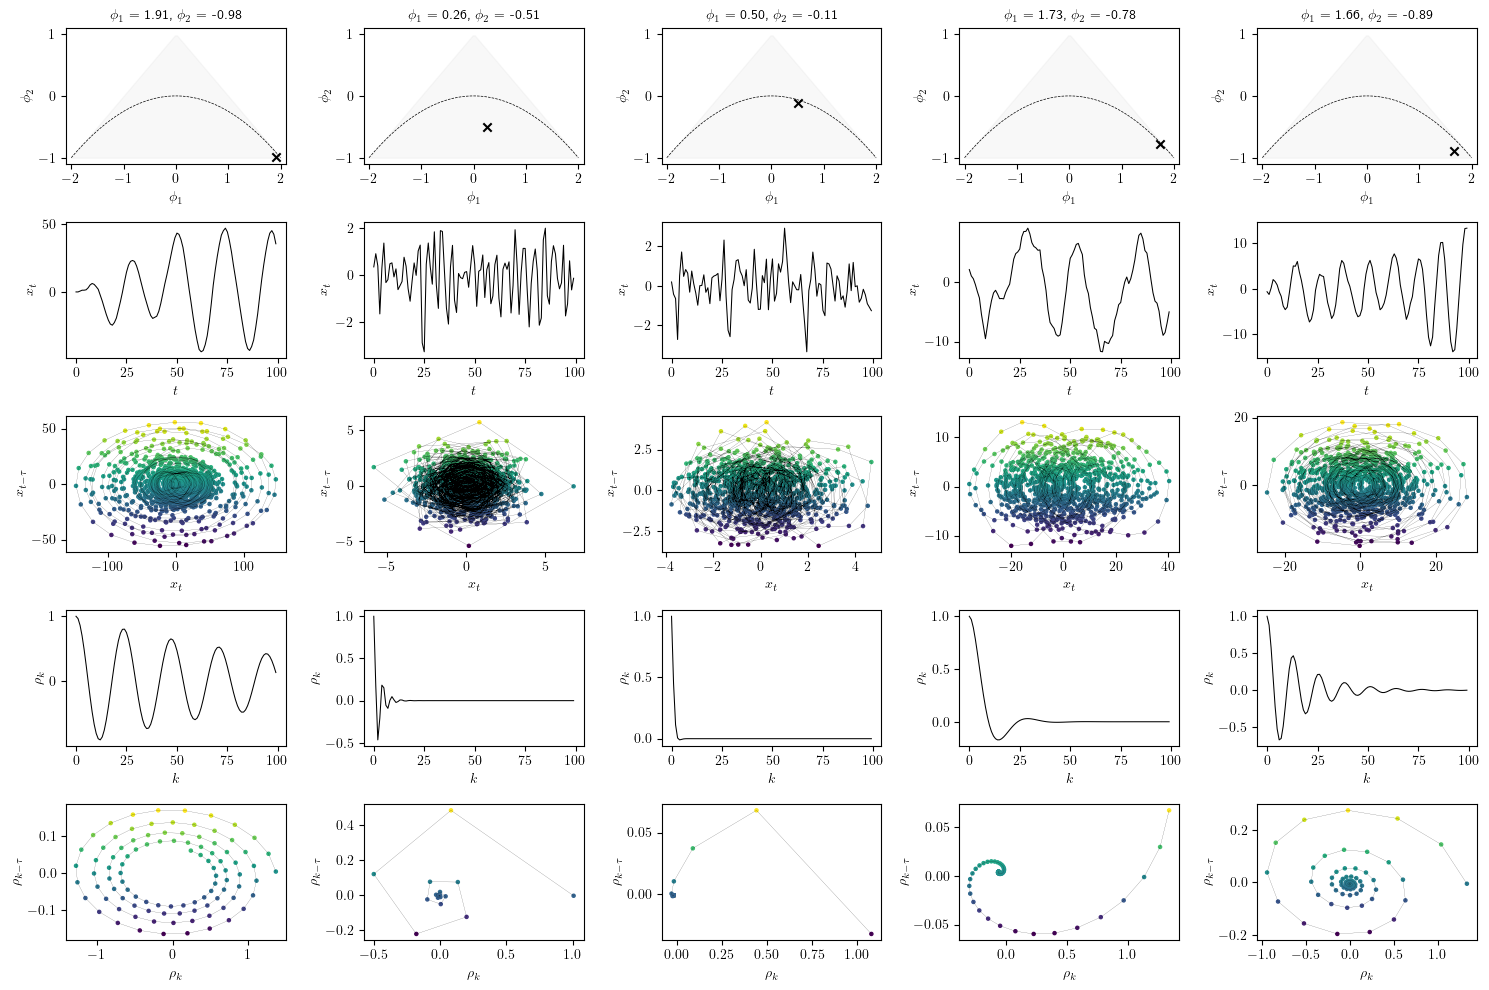

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from gtda.time_series import SingleTakensEmbedding
from persim import plot_diagrams
from ripser import ripser
from sklearn.decomposition import PCA

from src import acf_utils, plts, sim


def gen_ar2_coeffs(oscillatory=False, random_seed=0):
    """generate coefficients for an stationary AR(2) process"""
    rng = np.random.default_rng(seed=random_seed)
    phi1 = rng.uniform(0, 2)
    if oscillatory:
        phi2 = rng.uniform(-1, -0.25 * phi1**2)
    else:
        phi2 = rng.uniform(np.max([-1, -0.25 * phi1**2]), np.min([1 + phi1, 1 - phi1]))
    return np.array([phi1, phi2])


def acf_to_psd(acf, sampling_rate=1):
    """convert ACF to PSD (Wiener-Kinchin Theorem)."""
    psd = (1 / 2 * np.pi) * np.fft.ifft(acf).real
    freqs = np.fft.fftfreq(len(acf), d=1.0 / sampling_rate)

    return freqs[1 : len(freqs) // 2], psd[1 : len(psd) // 2]


def sliding_window(X, window_size=2, stride=1):
    """sliding window embedding of a 1D array."""
    return np.array([X[i : i + window_size] for i in range(0, len(X) - window_size + 1, stride)])


emb = SingleTakensEmbedding(parameters_type="search", n_jobs=-1)
pca = PCA(n_components=2)

n_sims, n_timepoints, n_lags = 5, 1000, 100

fig, axs = plt.subplots(nrows=5, ncols=n_sims, figsize=(15, 10))
plot_kwargs = dict(ls="-", lw=0.75)
scatter_kwargs = dict(s=5)

for idx in range(n_sims):
    phis = gen_ar2_coeffs(oscillatory=True, random_seed=idx + 10)

    X = sim.sim_ar(phis, n_timepoints, random_seed=idx).squeeze()
    # X = (X - X.mean(axis=0)) / X.std(axis=0)
    X_emb = emb.fit_transform(X)
    X_emb_pc = pca.fit_transform(X_emb)

    X_acf = acf_utils.ar_to_acf(phis, n_lags=n_lags)
    X_acf_emb = emb.fit_transform(X_acf)
    X_acf_emb_pc = pca.fit_transform(X_acf_emb)

    # stationarity triangle
    axs[0, idx].set_title(rf"$\phi_1$ = {phis[0]:.2f}, $\phi_2$ = {phis[1]:.2f}", fontsize=10)
    plts.plot_stationarity_triangle(axs[0, idx], fill_alpha=0.05, annotate=False)
    axs[0, idx].scatter(phis[0], phis[1], c="k", marker="x")

    # x_t
    axs[1, idx].plot(X[:n_lags], c="k", **plot_kwargs)
    axs[1, idx].set_xlabel(r"$t$")
    axs[1, idx].set_ylabel(r"$x_t$")

    # x_t embedding
    axs[2, idx].plot(X_emb_pc[:, 0], X_emb_pc[:, 1], c="k", lw=0.1)
    axs[2, idx].scatter(X_emb_pc[:, 0], X_emb_pc[:, 1], c=X_emb_pc[:, 1], **scatter_kwargs)
    axs[2, idx].set_xlabel(r"$x_t$")
    axs[2, idx].set_ylabel(r"$x_{t-\tau}$")

    # rho_t
    axs[3, idx].plot(X_acf, c="k", **plot_kwargs)
    axs[3, idx].set_xlabel(r"$k$")
    axs[3, idx].set_ylabel(r"$\rho_k$")

    # rho_t embedding
    axs[4, idx].plot(X_acf_emb_pc[:, 0], X_acf_emb_pc[:, 1], c="k", lw=0.1)
    axs[4, idx].scatter(
        X_acf_emb_pc[:, 0], X_acf_emb_pc[:, 1], c=X_acf_emb_pc[:, 1], **scatter_kwargs
    )
    axs[4, idx].set_xlabel(r"$\rho_k$")
    axs[4, idx].set_ylabel(r"$\rho_{k-\tau}$")


fig.tight_layout()